In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ayarlar
workspace_path = "/Users/beyzakutuk/desktop/Görüntü_İşleme/"
destination_folder = workspace_path + "hard-fake-vs-real-faces/"
batch_size = 64  # bir eğitim döngüsüne kaç tane veri verileceğini belirler (aynı anda)
image_size = 224

# Veri yükleme ve ön işleme
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(root=os.path.join(destination_folder, "train"), transform=transform)
validation_data = ImageFolder(root=os.path.join(destination_folder, "validation"), transform=transform)
test_data = ImageFolder(root=os.path.join(destination_folder, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [2]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_large(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /Users/beyzakutuk/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100.0%


In [10]:
# Eğitim
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # Doğrulama aşaması
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
    accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    # Early stopping kontrolü
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break


Epoch 1/20, Loss: 0.0268, Validation Accuracy: 1.0000
Epoch 2/20, Loss: 0.0217, Validation Accuracy: 1.0000
Epoch 3/20, Loss: 0.0250, Validation Accuracy: 1.0000
Epoch 4/20, Loss: 0.0207, Validation Accuracy: 1.0000
Epoch 5/20, Loss: 0.0240, Validation Accuracy: 1.0000
Epoch 6/20, Loss: 0.0234, Validation Accuracy: 1.0000
Early stopping triggered.


In [6]:
torch.save(model.state_dict(), f"{destination_folder}/{epoch+1}LargeNetEpoch.pth")

In [4]:
# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

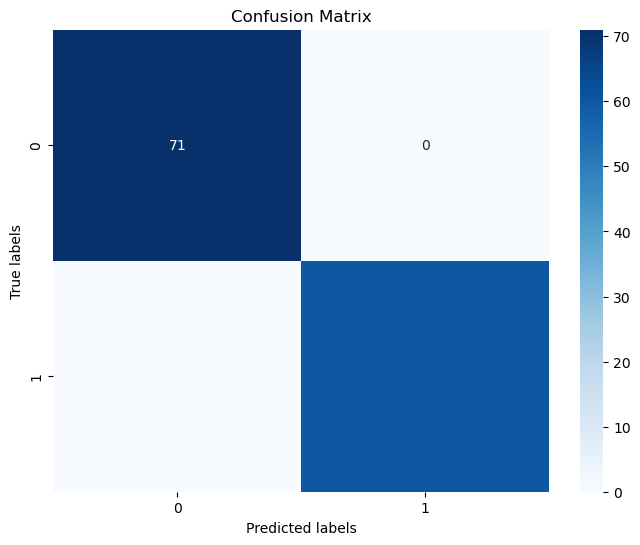

<function confusion_matrix at 0x14ba3e320>


In [7]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)

In [9]:
print(conf_matrix)

[[71  0]
 [ 0 60]]


In [3]:
# Model oluşturma
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(num_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchimg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/beyzakutuk/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100.0%


In [4]:
# Eğitim
num_epochs = 20
best_accuracy = 0.0
early_stopping_counter = 0

for epoch in range(num_epochs):
    # Eğitim aşaması
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # Doğrulama aşaması
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
    accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    # Early stopping kontrolü
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 5:
            print("Early stopping triggered.")
            break

Epoch 1/20, Loss: 0.6117, Validation Accuracy: 0.5875
Epoch 2/20, Loss: 0.4420, Validation Accuracy: 0.5681
Epoch 3/20, Loss: 0.3057, Validation Accuracy: 0.5992
Epoch 4/20, Loss: 0.2216, Validation Accuracy: 0.6381
Epoch 5/20, Loss: 0.1641, Validation Accuracy: 0.6887
Epoch 6/20, Loss: 0.1310, Validation Accuracy: 0.7471
Epoch 7/20, Loss: 0.1083, Validation Accuracy: 0.8249
Epoch 8/20, Loss: 0.0839, Validation Accuracy: 0.8482
Epoch 9/20, Loss: 0.0734, Validation Accuracy: 0.8949
Epoch 10/20, Loss: 0.0712, Validation Accuracy: 0.9300
Epoch 11/20, Loss: 0.0591, Validation Accuracy: 0.9416
Epoch 12/20, Loss: 0.0528, Validation Accuracy: 0.9494
Epoch 13/20, Loss: 0.0458, Validation Accuracy: 0.9611
Epoch 14/20, Loss: 0.0429, Validation Accuracy: 0.9728
Epoch 15/20, Loss: 0.0417, Validation Accuracy: 0.9844
Epoch 16/20, Loss: 0.0346, Validation Accuracy: 0.9883
Epoch 17/20, Loss: 0.0358, Validation Accuracy: 0.9922
Epoch 18/20, Loss: 0.0331, Validation Accuracy: 0.9961
Epoch 19/20, Loss: 

In [9]:
torch.save(model.state_dict(), f"{destination_folder}/{epoch+1}smallNetEpoch.pth")

In [5]:
# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

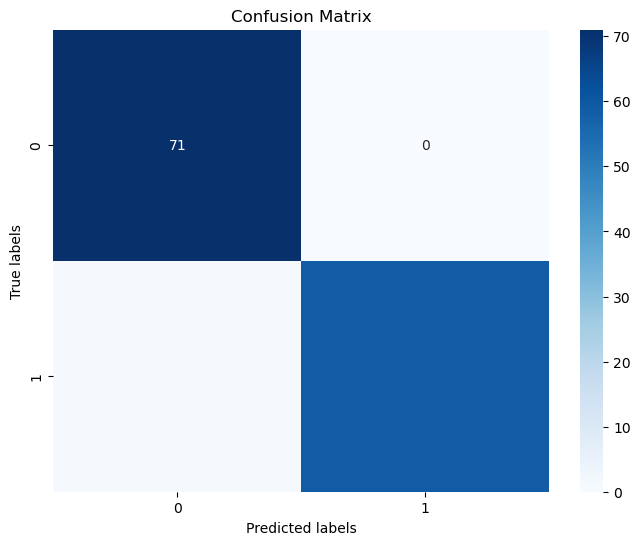

<function confusion_matrix at 0x154cea680>


In [6]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)

In [7]:
print(conf_matrix)

[[71  0]
 [ 1 59]]
